<a href="https://colab.research.google.com/github/MarkusNeusinger/defichain-data-toolkit/blob/main/notebooks/dusd_buy_needed_peg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Daily DUSD / USD needed to reach PEG

In [1]:
import os, sys
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import concurrent.futures
from google.colab import files
from matplotlib.dates import DateFormatter, DayLocator, WeekdayLocator

# import defichain-data-toolkit utils, style
if os.path.isdir('defichain-data-toolkit'): os.system('rm -rf defichain-data-toolkit')
!git clone https://github.com/MarkusNeusinger/defichain-data-toolkit.git
sys.path.insert(1, 'defichain-data-toolkit')

from utils import fetch_history
plt.style.use('/content/defichain-data-toolkit/utils/defichain.mplstyle')

print(f"\nNotebook last run: {datetime.utcnow()}")

Cloning into 'defichain-data-toolkit'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 77 (delta 25), reused 30 (delta 9), pack-reused 0
Receiving objects: 100% (77/77), 3.10 MiB | 4.19 MiB/s, done.
Resolving deltas: 100% (25/25), done.

Notebook last run: 2023-12-25 21:13:37.784969


In [2]:
# functions
def calculate_pool_balance_and_costs(start_token1, start_token2, step_size, target_ratio):
    token1 = start_token1  # This is the token being added to the pool
    token2 = start_token2  # This is the token being purchased
    k = token1 * token2  # Constant k from the Uniswap formula x*y=k

    number_of_steps = 0
    total_costs_token1 = 0
    total_purchased_token2 = 0

    while token1 / token2 < target_ratio:
        token1_old = token1
        token1 += step_size
        token2_old = token2
        token2 = k / token1

        cost_token1 = token1 - token1_old
        purchased_token2 = token2_old - token2
        total_costs_token1 += cost_token1
        total_purchased_token2 += purchased_token2

        number_of_steps += 1

    return number_of_steps, total_costs_token1, total_purchased_token2, token1, token2

def calculate_for_row(row):
    swap_step_size = 1  # use higher number for quicker calculation

    # For DUSDT-DUSD
    start_token1_dusdt = row['dusdt-dusddusdtreserve']
    start_token2_dusdt = row['dusdt-dusddusdreserve']
    _, total_costs_token1_dusdt, total_purchased_token2_dusdt, _, _ = calculate_pool_balance_and_costs(start_token1_dusdt, start_token2_dusdt, swap_step_size, 1)

    # For DUSDC-DUSD
    start_token1_dusdc = row['dusdc-dusddusdcreserve']
    start_token2_dusdc = row['dusdc-dusddusdreserve']
    _, total_costs_token1_dusdc, total_purchased_token2_dusdc, _, _ = calculate_pool_balance_and_costs(start_token1_dusdc, start_token2_dusdc, swap_step_size, 1)

    # For DEUROC-DUSD
    start_token1_deuroc = row['deuroc-dusddeurocreserve']
    start_token2_deuroc = row['deuroc-dusddusdreserve']
    _, total_costs_token1_deuroc, total_purchased_token2_deuroc, _, _ = calculate_pool_balance_and_costs(start_token1_deuroc, start_token2_deuroc, swap_step_size, row['usd:euroc'])

    # For DUSD-DFI
    start_token1_dfi = row['dusd-dfidfireserve']
    start_token2_dfi = row['dusd-dfidusdreserve']
    _, total_costs_token1_dfi, total_purchased_token2_dfi, _, _ = calculate_pool_balance_and_costs(start_token1_dfi, start_token2_dfi, swap_step_size, row['usd:dfi'])


    return pd.Series([
        total_purchased_token2_dusdt, total_costs_token1_dusdt,
        total_purchased_token2_dusdc, total_costs_token1_dusdc,
        total_purchased_token2_deuroc, total_costs_token1_deuroc,
        total_purchased_token2_dfi, total_costs_token1_dfi,
    ])

def parallel_apply(df, func, num_workers):
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
        # Split dataframe into chunks and process each chunk in parallel
        chunks = np.array_split(df, num_workers)
        results = executor.map(func, chunks)
        return pd.concat(results)

def apply_calculations_to_chunk(chunk):
    return chunk.apply(calculate_for_row, axis=1)

In [3]:
# fetching data
df = fetch_history('daily', ['dUSDT-DUSD DUSD Reserve', 'dUSDT-DUSD dUSDT Reserve',
                             'dUSDC-DUSD DUSD Reserve', 'dUSDC-DUSD dUSDC Reserve',
                             'dEUROC-DUSD DUSD Reserve', 'dEUROC-DUSD dEUROC Reserve',
                             'DUSD-DFI DUSD Reserve', 'DUSD-DFI DFI Reserve', 'EUROC:USD', 'DFI:USD'],
                   from_timestamp='2023-12-01')
df.sort_values('datetime_utc', ascending=True, inplace=True)
df['usd:euroc'] = 1 / df['euroc:usd']
df['usd:dfi'] = 1 / df['dfi:usd']
df.tail()

100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


,datetime_utc,dusdt-dusddusdtreserve,dusd-dfidfireserve,dusdc-dusddusdcreserve,dusd-dfidusdreserve,dusdt-dusddusdreserve,dusdc-dusddusdreserve,deuroc-dusddusdreserve,deuroc-dusddeurocreserve,dfi:usd,euroc:usd,usd:euroc,usd:dfi
20,2023-12-21,464321.376296,9.719425e+06,471035.558951,7.587854e+06,2.461793e+06,2.500292e+06,904354.386657,155929.102569,0.148209,1.094023,0.914058,6.747247
21,2023-12-22,435463.815103,9.716704e+06,465550.892372,7.523931e+06,2.280760e+06,2.447625e+06,892823.696015,154840.704346,0.151588,1.097527,0.911140,6.596828
22,2023-12-23,427940.592626,9.789166e+06,472754.623176,7.325674e+06,2.121139e+06,2.411664e+06,867990.045862,154115.976003,0.150688,1.099928,0.909150,6.636224
23,2023-12-24,441278.987444,1.057156e+07,494490.842420,6.763204e+06,2.041467e+06,2.300348e+06,832487.335948,162573.738009,0.148379,1.099832,0.909230,6.739499
24,2023-12-25,452361.863616,1.123962e+07,508342.128951,6.343001e+06,1.953879e+06,2.231101e+06,814143.844938,168348.449696,0.146288,1.099228,0.909730,6.835834


In [8]:
# simulate swaps, calculate buy needed
num_workers = 12
df[['dusdt_dusd_buy_needed', 'dusdt_dusd_token1_cost',
    'dusdc_dusd_buy_needed', 'dusdc_dusd_token1_cost',
    'deuroc_dusd_buy_needed', 'deuroc_dusd_token1_cost',
    'dfi_dusd_buy_needed', 'dfi_dusd_token1_cost']] = parallel_apply(df, apply_calculations_to_chunk, num_workers)

df['dusd_buy_needed'] = df['dfi_dusd_buy_needed'] + df['dusdc_dusd_buy_needed'] + df['dusdt_dusd_buy_needed'] + df['deuroc_dusd_buy_needed']
df['usd_buy_needed'] = df['dfi_dusd_token1_cost'] * df['dfi:usd'] + df['dusdc_dusd_token1_cost'] + df['dusdt_dusd_token1_cost'] + df['deuroc_dusd_token1_cost'] * df['euroc:usd']

df.tail()

,datetime_utc,dusdt-dusddusdtreserve,dusd-dfidfireserve,dusdc-dusddusdcreserve,dusd-dfidusdreserve,dusdt-dusddusdreserve,dusdc-dusddusdreserve,deuroc-dusddusdreserve,deuroc-dusddeurocreserve,dfi:usd,...,dusdt_dusd_buy_needed,dusdt_dusd_token1_cost,dusdc_dusd_buy_needed,dusdc_dusd_token1_cost,deuroc_dusd_buy_needed,deuroc_dusd_token1_cost,dfi_dusd_buy_needed,dfi_dusd_token1_cost,dusd_buy_needed,usd_buy_needed
20,2023-12-21,464321.376296,9.719425e+06,471035.558951,7.587854e+06,2.461793e+06,2.500292e+06,904354.386657,155929.102569,0.148209,...,1.392652e+06,604820.0,1.415061e+06,614196.0,511577.564050,203092.0,4.281751e+06,12587673.0,7.601042e+06,3.306805e+06
21,2023-12-22,435463.815103,9.716704e+06,465550.892372,7.523931e+06,2.280760e+06,2.447625e+06,892823.696015,154840.704346,0.151588,...,1.284172e+06,561125.0,1.380154e+06,601920.0,503301.914184,200070.0,4.194927e+06,12244163.0,7.362555e+06,3.238695e+06
22,2023-12-23,427940.592626,9.789166e+06,472754.623176,7.325674e+06,2.121139e+06,2.411664e+06,867990.045862,154115.976003,0.150688,...,1.168395e+06,524804.0,1.343898e+06,595012.0,484403.679352,194622.0,4.038399e+06,12025933.0,7.035096e+06,3.146051e+06
23,2023-12-24,441278.987444,1.057156e+07,494490.842420,6.763204e+06,2.041467e+06,2.300348e+06,832487.335948,162573.738009,0.148379,...,1.092333e+06,507856.0,1.233812e+06,572047.0,446674.924306,188220.0,3.506098e+06,11379708.0,6.278918e+06,2.975423e+06
24,2023-12-25,452361.863616,1.123962e+07,508342.128951,6.343001e+06,1.953879e+06,2.231101e+06,814143.844938,168348.449696,0.146288,...,1.013741e+06,487777.0,1.166131e+06,556629.0,425994.850497,184763.0,3.113559e+06,10836308.0,5.719425e+06,2.832724e+06


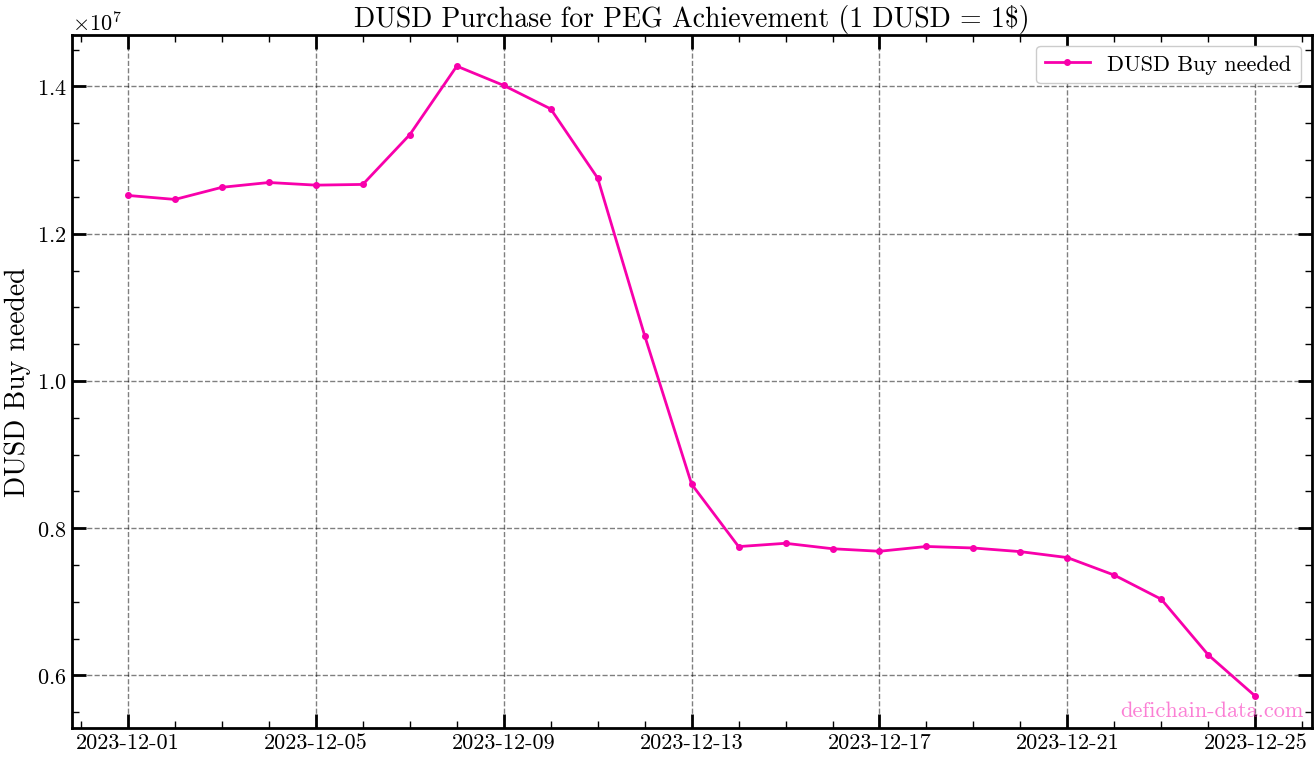

In [5]:
# Plotting DUSD Purchase for PEG
fig, axs = plt.subplots()

axs.plot(df['datetime_utc'], df['dusd_buy_needed'], label='DUSD Buy needed', marker='o')

axs.set_title('DUSD Purchase for PEG Achievement (1 DUSD = 1$)')
axs.set_ylabel('DUSD Buy needed')
axs.legend()

axs.text(0.92, 0.025, 'defichain-data.com', ha='center', va='center', transform=axs.transAxes,
         fontsize=16, color='#F800AB', alpha=0.5)

plt.savefig('dusd_buy_needed.png')
plt.show()

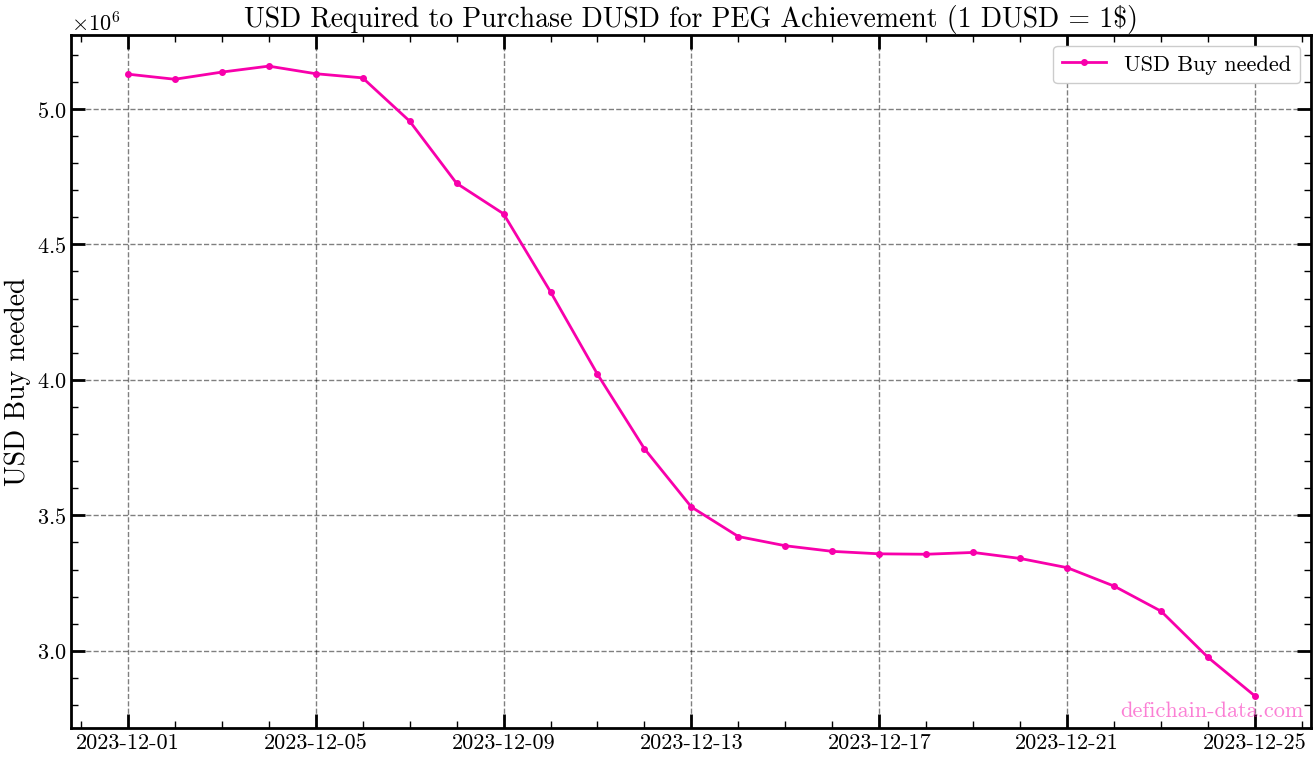

In [6]:
# Plotting USD Purchase for PEG
fig, axs = plt.subplots()

axs.plot(df['datetime_utc'], df['usd_buy_needed'], label='USD Buy needed', marker='o')

axs.set_title('USD Required to Purchase DUSD for PEG Achievement (1 DUSD = 1$)')
axs.set_ylabel('USD Buy needed')
axs.legend()

axs.text(0.92, 0.025, 'defichain-data.com', ha='center', va='center', transform=axs.transAxes,
         fontsize=16, color='#F800AB', alpha=0.5)

plt.savefig('usd_buy_needed.png')
plt.show()

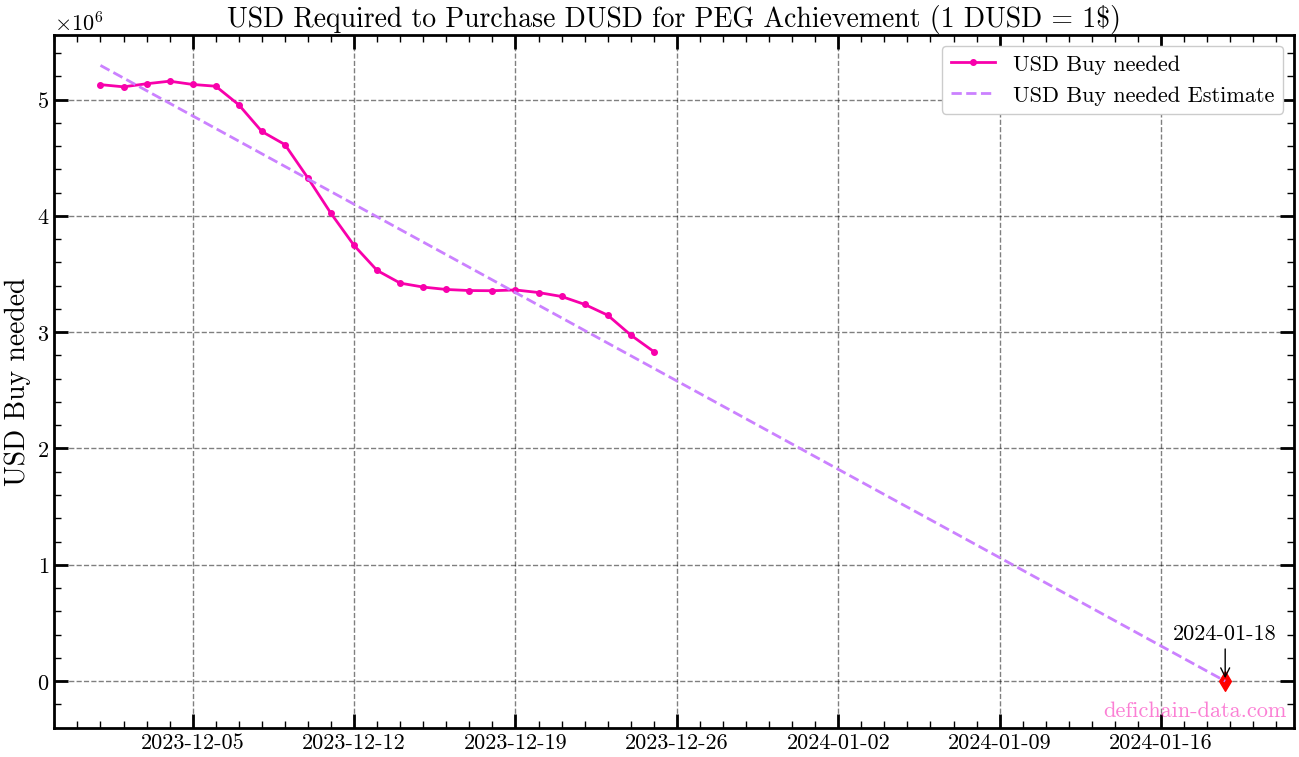

In [7]:
# Plotting USD Purchase for PEG and Estimate
z1 = np.polyfit(pd.to_datetime(df['datetime_utc']).astype('int64'), df['usd_buy_needed'], 1)
p1 = np.poly1d(z1)

zero_crossing = -z1[1]/z1[0]
zero_crossing_date = pd.to_datetime(zero_crossing).strftime('%Y-%m-%d')

min_date = pd.to_datetime(df['datetime_utc']).min()
max_date = pd.to_datetime(zero_crossing)
extended_range = pd.date_range(start=min_date, end=max_date, periods=100).astype('int64')

fig, axs = plt.subplots()

axs.plot(df['datetime_utc'], df['usd_buy_needed'], marker='o', label='USD Buy needed')
axs.plot(pd.to_datetime(extended_range), p1(extended_range), linestyle='--', label='USD Buy needed Estimate')
axs.scatter(x=max_date, y=0, color='red', marker='d', s=100)

axs.set_title('USD Required to Purchase DUSD for PEG Achievement (1 DUSD = 1$)')
axs.set_ylabel('USD Buy needed')
axs.legend()

axs.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
axs.xaxis.set_major_locator(WeekdayLocator(interval=1))
axs.xaxis.set_minor_locator(DayLocator(interval=1))

axs.annotate(zero_crossing_date, xy=(max_date, 0), xytext=(0,30),
             textcoords='offset points', arrowprops=dict(arrowstyle='->'), fontsize=16, ha='center')

axs.set_ylim([-400000, None])
axs.set_xlim(min_date - pd.Timedelta(days=2), max_date + pd.Timedelta(days=3))

axs.text(0.92, 0.025, 'defichain-data.com', ha='center', va='center', transform=axs.transAxes,
         fontsize=16, color='#F800AB', alpha=0.5)

plt.savefig('USD_Buy_needed_estimate.png')
plt.show()